In [1]:
# !pip install torch torchvision torchaudio transformers timm librosa matplotlib streamlit pandas numpy pillow ipywidgets

In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torchaudio
from torchaudio import transforms as audio_transforms
from transformers import CLIPVisionModel          # instead of torchvision resnet for vision branch
from torch.cuda.amp import autocast, GradScaler   # mixed‑precision training
from torch.optim import AdamW
import librosa
import librosa.display
import matplotlib.pyplot as plt
from PIL import Image
import IPython.display as ipd
from transformers import CLIPTokenizer, CLIPTextModel, CLIPProcessor
from tqdm.notebook import tqdm
import time
import random
import warnings
warnings.filterwarnings('ignore')

2025-05-09 13:44:20.532406: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746798260.555401    3007 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746798260.562565    3007 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 2. Dataset & preprocessing

### 2.1 Emotion label set
The seven basic emotion classes shared by **FER‑2013** and **CREMA‑D**:

ID: 0-angry, 1-disgust, 2-fear, 3-happy, 4-neutral, 5-sad, 6-surprise

Using identical labels simplifies the **cross‑modal contrastive loss** because one‑hot equivalence establishes positive pairs between image & audio samples.

In [4]:
# Define emotion classes (common for both audio and image)
EMOTIONS = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

### 2.2 Paths

In [5]:
# Define paths
FER_IMAGE_PATH = "/kaggle/input/fer2013/train"
CREMA_D_AUDIO_PATH = "/kaggle/input/cremad/AudioWAV"

### 2.3 Image augmentations 
*RandomResizedCrop* and colour jitter lend robustness to viewpoint & lighting changes. 
Normalisation uses the ImageNet mean/STD expected by the CLIP/Vision backbones.

In [6]:
image_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=.2, contrast=.2, saturation=.2, hue=.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

### 2.4 Audio pipeline
1. Waveform loading
2. Mel‑spectrogram
3. SpecAugment style frequency & time masking
4. Convert to 3‑channel pseudo‑image so the vision backbone can process it.

In [7]:
# Audio preprocessing functions
def load_audio(file_path, sr=16000, max_length=5):
    """Load and preprocess audio file"""
    try:
        # Load audio with librosa
        audio, sr = librosa.load(file_path, sr=sr, mono=True)
        
        # Make sure audio is the right length
        if len(audio) > sr * max_length:
            audio = audio[:sr * max_length]
        else:
            # Pad with zeros if audio is too short
            audio = np.pad(audio, (0, max(0, sr * max_length - len(audio))), 'constant')
        
        return audio, sr
    except Exception as e:
        print(f"Error loading audio file {file_path}: {e}")
        return None, None

In [8]:
def extract_melspectrogram(audio, sr, n_mels=128, n_fft=1024, hop_length=512):
    """Extract mel spectrogram from audio"""
    mel_spec = librosa.feature.melspectrogram(
        y=audio, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length
    )
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

In [9]:
def audio_to_image(mel_spec):
    """Convert mel spectrogram to image-like tensor"""
    # Normalize to [0, 1]
    mel_spec = (mel_spec - mel_spec.min()) / (mel_spec.max() - mel_spec.min())
    
    # Convert to 3-channel image by repeating
    mel_spec = np.stack([mel_spec, mel_spec, mel_spec], axis=0)
    return torch.FloatTensor(mel_spec)

## 3. Dataset classes

### **EmotionImageDataset** loads FER images tensor

In [10]:
# Define Datasets
class EmotionImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.samples = []
        
        # Each subfolder is an emotion category
        for emotion_idx, emotion in enumerate(EMOTIONS):
            emotion_folder = os.path.join(image_dir, emotion)
            if os.path.isdir(emotion_folder):
                for img_name in os.listdir(emotion_folder):
                    if img_name.endswith(('.jpg', '.jpeg', '.png')):
                        img_path = os.path.join(emotion_folder, img_name)
                        self.samples.append((img_path, emotion_idx))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label, EMOTIONS[label]

### **EmotionAudioDataset** loads CREMA–D wav files mel‑spectrogram‑image tensor

In [11]:
class EmotionAudioDataset(Dataset):
    def __init__(self, audio_dir):
        self.audio_dir = audio_dir
        self.samples = []
        
        # Parse CREMA-D filenames which contain emotion info
        # Format: ActorID_SentenceID_EmotionType_EmotionalIntensity_StatementID
        for filename in os.listdir(audio_dir):
            if filename.endswith('.wav'):
                parts = filename.split('_')
                if len(parts) >= 3:
                    emotion_code = parts[2]
                    # Map CREMA-D emotion codes to our emotion classes
                    emotion_map = {
                        'ANG': 'angry',
                        'DIS': 'disgust', 
                        'FEA': 'fear', 
                        'HAP': 'happy', 
                        'NEU': 'neutral', 
                        'SAD': 'sad'
                    }
                    
                    if emotion_code in emotion_map:
                        emotion = emotion_map[emotion_code]
                        if emotion in EMOTIONS:
                            emotion_idx = EMOTIONS.index(emotion)
                            audio_path = os.path.join(audio_dir, filename)
                            self.samples.append((audio_path, emotion_idx))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        audio_path, label = self.samples[idx]
        
        # Load and preprocess audio
        audio, sr = load_audio(audio_path)
        if audio is None:
            # Return a dummy tensor if audio loading failed
            return torch.zeros((3, 128, 128)), label, EMOTIONS[label]
        
        # Extract mel spectrogram
        mel_spec = extract_melspectrogram(audio, sr)

        freq_mask = torchaudio.transforms.FrequencyMasking(freq_mask_param=12)
        time_mask = torchaudio.transforms.TimeMasking(time_mask_param=30)
        mel_spec = freq_mask(torch.tensor(mel_spec))
        mel_spec = time_mask(mel_spec)
        mel_spec = mel_spec.numpy()
        
        # Convert to image-like tensor
        audio_tensor = audio_to_image(mel_spec)
        
        return audio_tensor, label, EMOTIONS[label]

## 4. Model architecture

### The network follows the **AudioCLIP** blueprint:
1. **Text encoder** – frozen `CLIPTextModel` produces 512‑d sentence embeddings for prompts like “*a happy expression*”.
2. **Vision encoder** – frozen ViT‑B/32 up to pooled output → learnable linear projection → 512‑d.
3. **Audio encoder** – **ESResNeXt‑50** front‑end (trainable) → linear projection → 512‑d.
4. **Classifier head** – linear → 7 logits (supervised cross‑entropy)

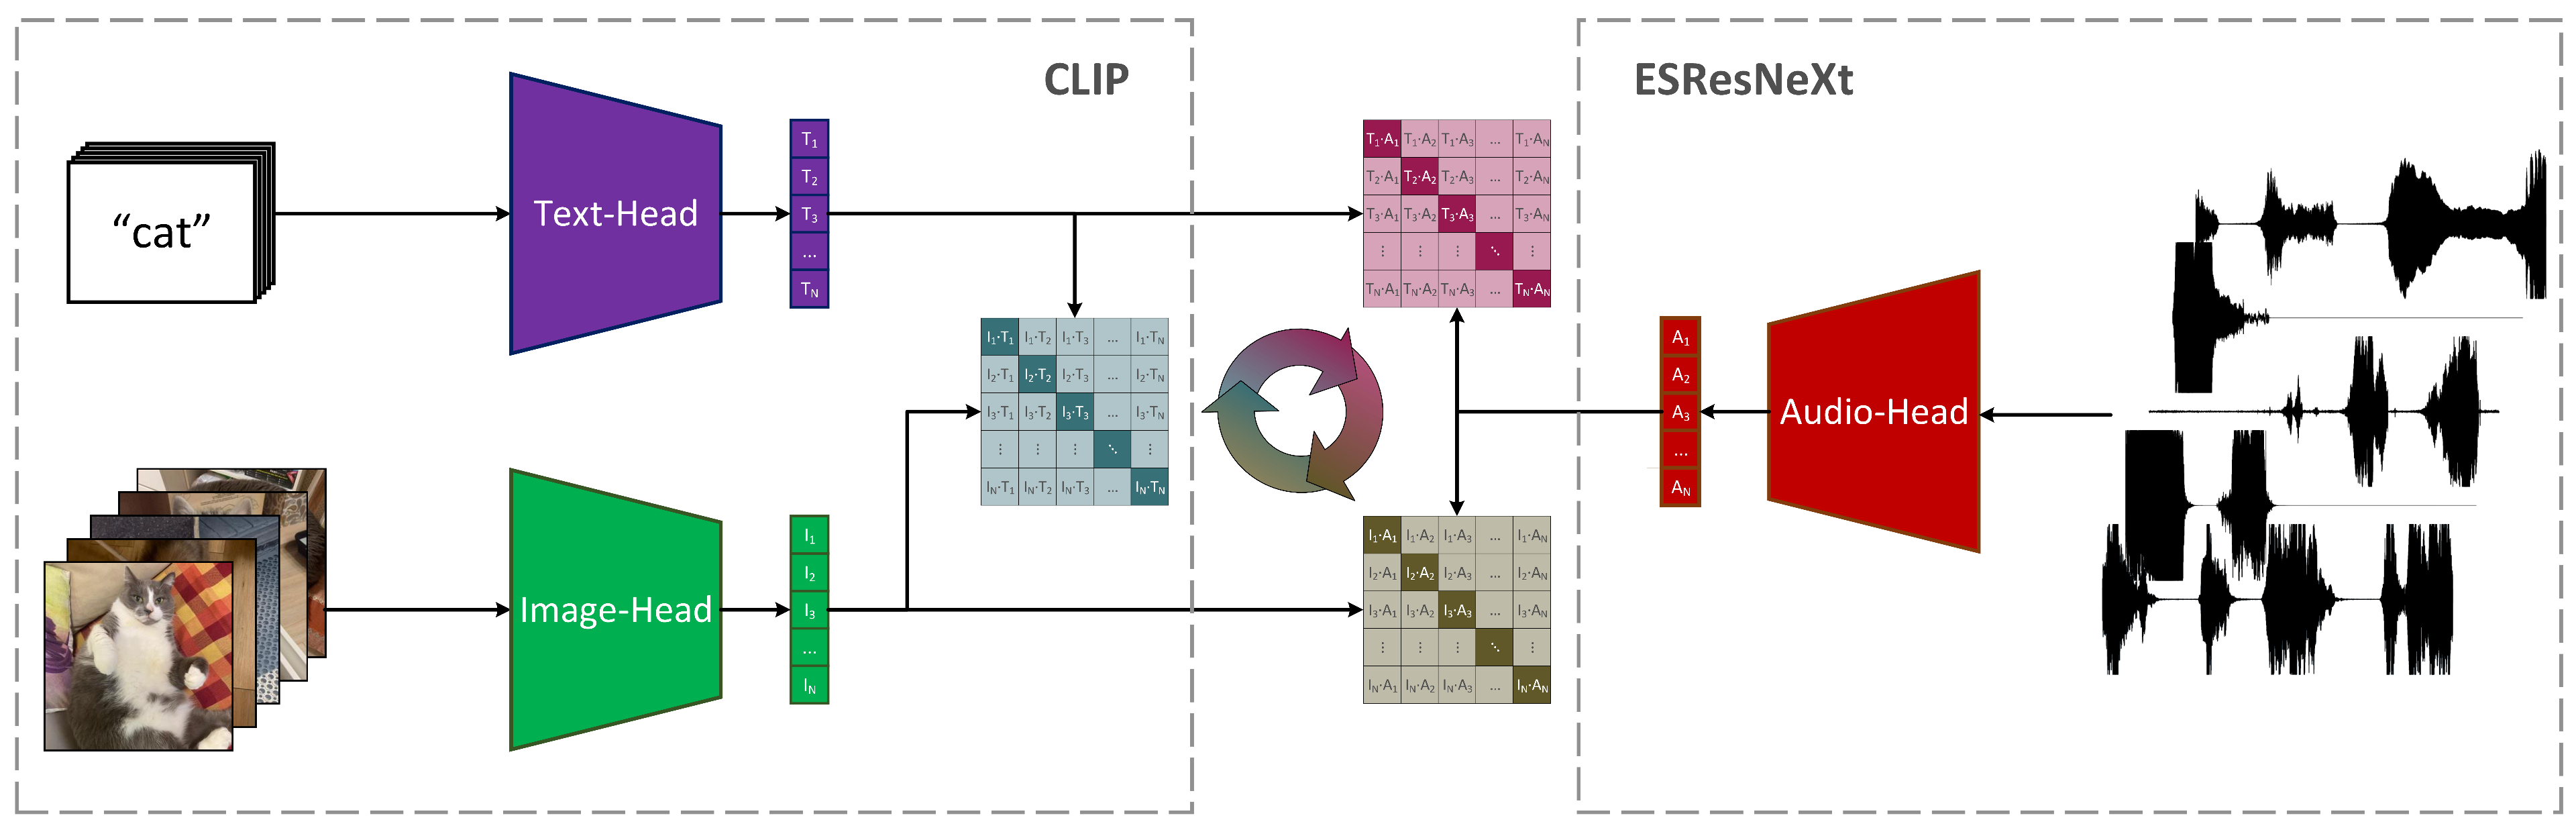
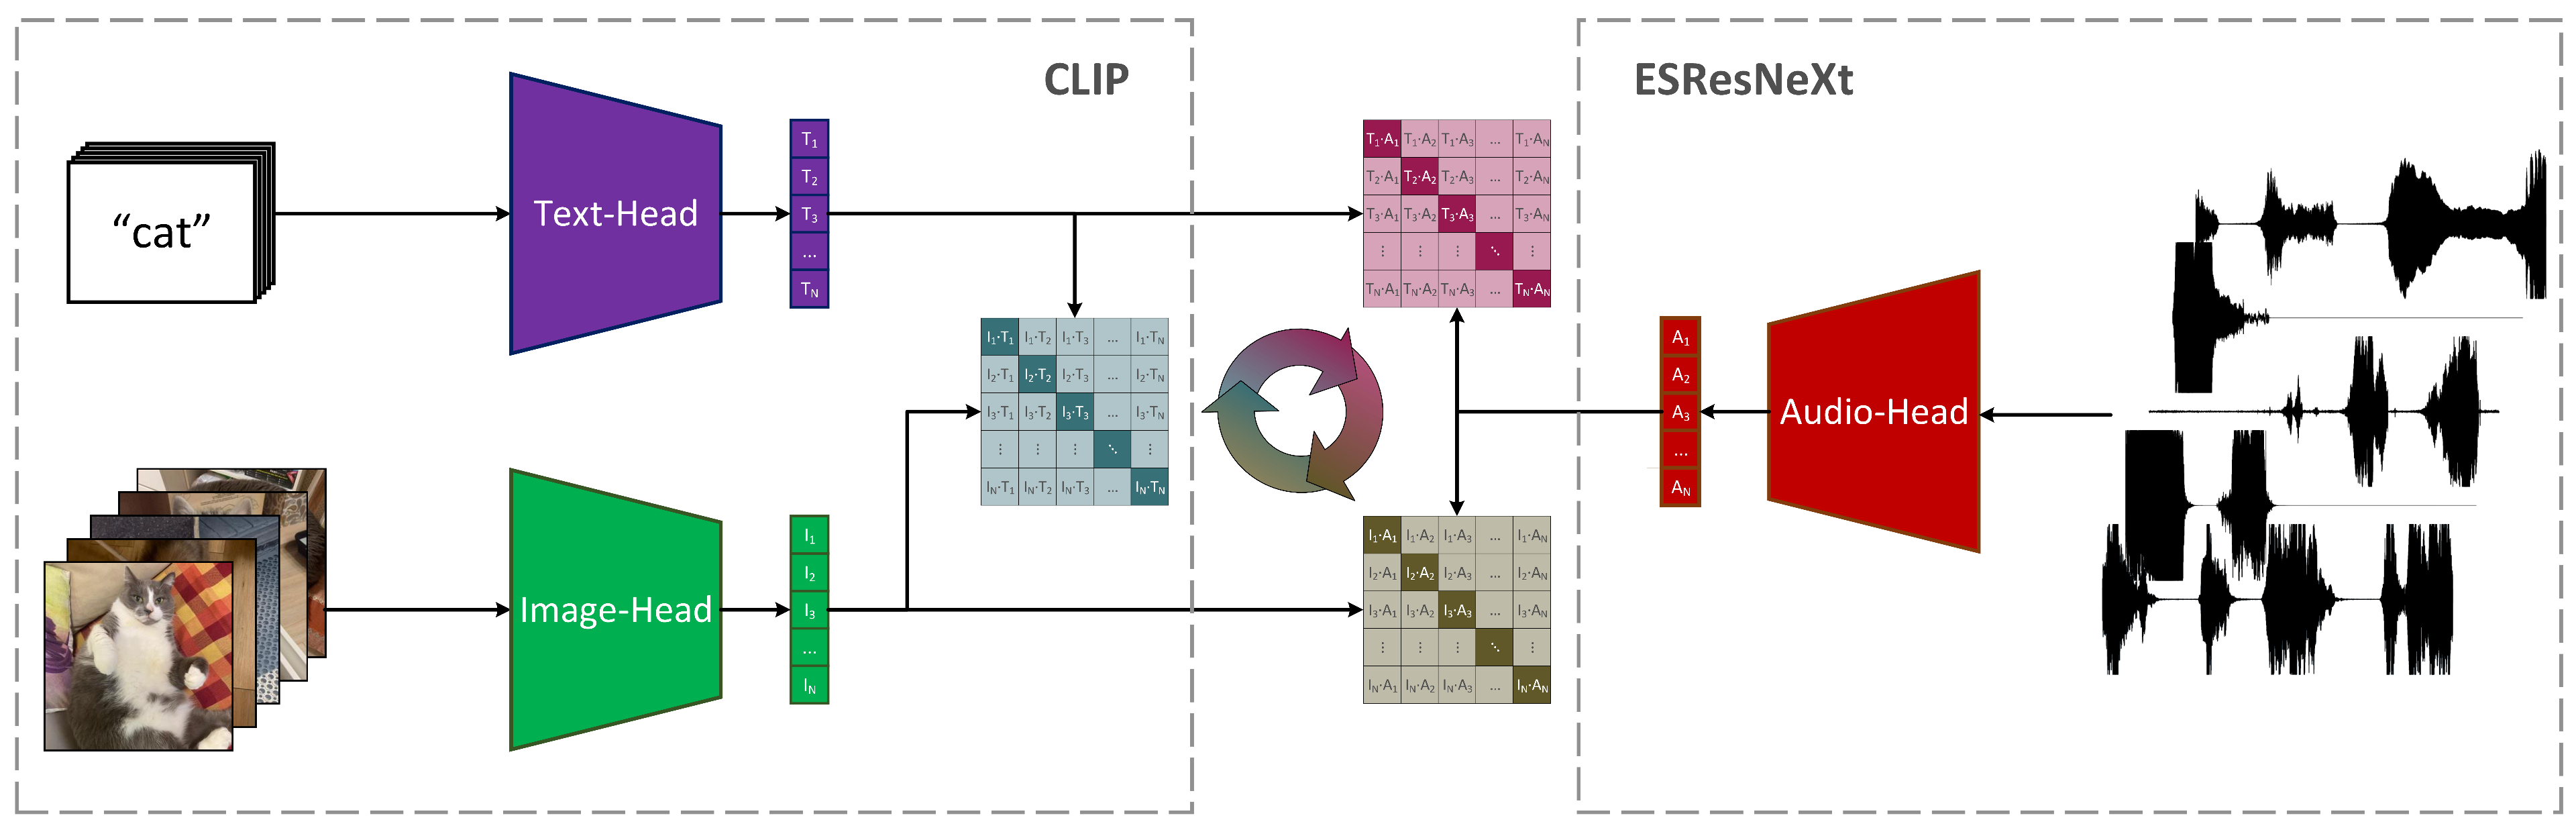

In [12]:
# AudioCLIP Model Implementation
class ESResNeXt(nn.Module):
    """Audio encoding head based on ESResNeXt as described in the paper"""
    def __init__(self, n_fft=256, hop_length=128, embedding_dim=512):  # Changed to 512 to match CLIP
        super(ESResNeXt, self).__init__()
        
        # Use ResNext50 as the base model
        base_model = models.resnext50_32x4d(pretrained=True)
        
        # Remove the final classification layer
        self.encoder = nn.Sequential(*list(base_model.children())[:-1])
        
        # Add a projection layer to match CLIP embedding dimension
        self.projection = nn.Linear(2048, embedding_dim)
    
    def forward(self, x):
        # x is a mel spectrogram converted to a 3-channel image
        features = self.encoder(x)
        features = features.view(features.size(0), -1)
        embeddings = self.projection(features)
        return F.normalize(embeddings, p=2, dim=1)

In [13]:
class AudioCLIPEmotionDetector(nn.Module):
    def __init__(self, embedding_dim=512, num_classes=len(EMOTIONS)):  # Changed to 512 to match CLIP
        super(AudioCLIPEmotionDetector, self).__init__()
        
        # Text encoder from CLIP (frozen)
        self.text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")
        self.tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
        
        # Image encoder from CLIP (we'll fine-tune this)
        self.clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        self.image_encoder = models.resnet50(pretrained=True)
        # Replace the final layer
        self.image_encoder.fc = nn.Linear(2048, embedding_dim)
        
        # Audio encoder (ESResNeXt)
        self.audio_encoder = ESResNeXt(embedding_dim=embedding_dim)
        
        # Classification head
        self.classifier = nn.Linear(embedding_dim, num_classes)

        self.vision_encoder = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32")
        for p in self.vision_encoder.parameters():
            p.requires_grad = False              # freeze backbone for stability
        self.image_proj = nn.Linear(
            self.vision_encoder.config.hidden_size, embedding_dim
            )
        
        # Freeze text encoder
        for param in self.text_encoder.parameters():
            param.requires_grad = False
    
    def _get_emotion_text_embeddings(self):
        """Create text embeddings for each emotion class"""
        emotion_prompts = [f"a {emotion} expression" for emotion in EMOTIONS]
        
        # Tokenize emotions
        inputs = self.tokenizer(emotion_prompts, padding=True, return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        # Get text embeddings
        with torch.no_grad():
            outputs = self.text_encoder(**inputs)
            text_embeddings = outputs.pooler_output
            text_embeddings = F.normalize(text_embeddings, p=2, dim=1)
        
        return text_embeddings
    
    # def encode_image(self, images):
    #     """Encode images to embedding space"""
    #     embeddings = self.image_encoder(images)
    #     return F.normalize(embeddings, p=2, dim=1)

    def encode_image(self, images):
        
        with torch.no_grad():                    # backbone frozen
            vision_out = self.vision_encoder(pixel_values=images).pooler_output
        embeddings = self.image_proj(vision_out)
        return F.normalize(embeddings, p=2, dim=1)
    
    def encode_audio(self, audio_specs):
        """Encode audio spectrograms to embedding space"""
        return self.audio_encoder(audio_specs)
    
    def forward(self, x, modality='image'):
        """Forward pass based on modality"""
        if modality == 'image':
            embeddings = self.encode_image(x)
        elif modality == 'audio':
            embeddings = self.encode_audio(x)
        else:
            raise ValueError(f"Unsupported modality: {modality}")
        
        # Generate emotion text embeddings on the fly (fixes the shape issue)
        emotion_text_embeddings = self._get_emotion_text_embeddings()
        
        # Compute similarity with emotion text embeddings
        similarity = embeddings @ emotion_text_embeddings.T
        
        # Classification logits
        logits = self.classifier(embeddings)
        
        return logits, similarity, embeddings

In [14]:
# Training functions
def train_model(model, image_loader, audio_loader, num_epochs=20):
    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.Adam([
    #     {'params': model.image_encoder.parameters(), 'lr': 1e-3},
    #     {'params': model.audio_encoder.parameters(), 'lr': 1e-3},
    #     {'params': model.classifier.parameters(), 'lr': 1e-3}
    # ])

    optimizer = AdamW([
        {'params': model.image_proj.parameters(),  'lr': 2e-4, 'weight_decay': 0.01},
        {'params': model.audio_encoder.parameters(),'lr': 2e-4, 'weight_decay': 0.01},
        {'params': model.classifier.parameters(),  'lr': 1e-3, 'weight_decay': 0.00},
    ])
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

    scaler = GradScaler()
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_image = 0
        correct_audio = 0
        total_image = 0
        total_audio = 0
        
        # Create a joint loader that cycles through the shorter dataset if needed
        # This prevents StopIteration errors when datasets have different sizes
        def cycle(iterable):
            while True:
                for x in iterable:
                    yield x
                    
        image_cycle = cycle(image_loader)
        audio_cycle = cycle(audio_loader)
        
        # Get the number of batches in the shorter dataset
        n_batches = min(len(image_loader), len(audio_loader))
        
        # Use tqdm for progress bar
        progress_bar = tqdm(range(n_batches), desc=f"Epoch {epoch+1}/{num_epochs}")
        
        for _ in progress_bar:
            # Get batches from both loaders
            images, image_labels, _ = next(image_cycle)
            audio_specs, audio_labels, _ = next(audio_cycle)
            
            images = images.to(device)
            image_labels = image_labels.to(device)
            audio_specs = audio_specs.to(device)
            audio_labels = audio_labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass for images
            image_logits, image_similarity, image_embeddings = model(images, modality='image')
            image_loss = criterion(image_logits, image_labels)
            
            # Forward pass for audio
            audio_logits, audio_similarity, audio_embeddings = model(audio_specs, modality='audio')
            audio_loss = criterion(audio_logits, audio_labels)
            
            # Contrastive loss between image and audio embeddings
            # We want similar emotions to have similar embeddings
            batch_size = images.size(0)
            labels_match = torch.eq(image_labels.view(-1, 1), audio_labels.view(1, -1)).float()
            
            # Compute similarity between image and audio embeddings
            similarity_matrix = torch.matmul(image_embeddings, audio_embeddings.T)
            
            # Temperature parameter for scaling
            temperature = 0.07
            
            # Cross-modal contrastive loss
            similarity_matrix = similarity_matrix / temperature
            contrastive_loss = -torch.mean(
                torch.sum(labels_match * F.log_softmax(similarity_matrix, dim=1), dim=1)
            )
            
            # Total loss
            loss = image_loss + audio_loss + 0.5 * contrastive_loss
            
            # Backward and optimize
            # loss.backward()
            # optimizer.step()

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            # Statistics
            running_loss += loss.item()
            
            # Image accuracy
            _, image_preds = torch.max(image_logits, 1)
            correct_image += (image_preds == image_labels).sum().item()
            total_image += image_labels.size(0)
            
            # Audio accuracy
            _, audio_preds = torch.max(audio_logits, 1)
            correct_audio += (audio_preds == audio_labels).sum().item()
            total_audio += audio_labels.size(0)
            
            # Update progress bar
            progress_bar.set_postfix({
                'loss': running_loss / (progress_bar.n + 1),
                'img_acc': 100 * correct_image / max(1, total_image),
                'audio_acc': 100 * correct_audio / max(1, total_audio)
            })
        
        # End of epoch
        epoch_loss = running_loss / n_batches
        image_acc = 100 * correct_image / total_image
        audio_acc = 100 * correct_audio / total_audio
        
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} - Image Acc: {image_acc:.2f}% - Audio Acc: {audio_acc:.2f}%")
        
        # Adjust learning rate
        scheduler.step(epoch_loss)
    
    return model

In [15]:
# Model evaluation
def evaluate_model(model, image_loader, audio_loader):
    model.eval()
    
    image_correct = 0
    image_total = 0
    audio_correct = 0
    audio_total = 0
    
    with torch.no_grad():
        # Evaluate on images
        for images, labels, _ in tqdm(image_loader, desc="Evaluating on images"):
            images = images.to(device)
            labels = labels.to(device)
            
            logits, _, _ = model(images, modality='image')
            _, preds = torch.max(logits, 1)
            
            image_correct += (preds == labels).sum().item()
            image_total += labels.size(0)
        
        # Evaluate on audio
        for audio_specs, labels, _ in tqdm(audio_loader, desc="Evaluating on audio"):
            audio_specs = audio_specs.to(device)
            labels = labels.to(device)
            
            logits, _, _ = model(audio_specs, modality='audio')
            _, preds = torch.max(logits, 1)
            
            audio_correct += (preds == labels).sum().item()
            audio_total += labels.size(0)
    
    image_acc = 100 * image_correct / image_total
    audio_acc = 100 * audio_correct / audio_total
    
    print(f"Image Accuracy: {image_acc:.2f}%")
    print(f"Audio Accuracy: {audio_acc:.2f}%")
    
    return image_acc, audio_acc

In [16]:
# Function to save model
def save_model(model, path="emotion_detector_audioclip.pth"):
    torch.save({
        'model_state_dict': model.state_dict(),
    }, path)
    print(f"Model saved to {path}")

In [17]:
# Function to load model
def load_model(path="emotion_detector_audioclip.pth"):
    model = AudioCLIPEmotionDetector().to(device)
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    return model

In [28]:
# Inference and visualization functions
def predict_emotion(model, input_data, modality='image'):
    """Predict emotion for an input (image or audio)"""
    model.eval()
    with torch.no_grad():
        # Process input based on modality
        if modality == 'image':
            if isinstance(input_data, str):  # If input is a file path
                img = Image.open(input_data).convert('RGB')
                img_tensor = image_transform(img).unsqueeze(0).to(device)
            else:  # If input is already an image
                img_tensor = image_transform(input_data).unsqueeze(0).to(device)
            
            logits, similarity, _ = model(img_tensor, modality='image')
        
        elif modality == 'audio':
            if isinstance(input_data, str):  # If input is a file path
                audio, sr = load_audio(input_data)
                if audio is None:
                    return None, None, None
                
                mel_spec = extract_melspectrogram(audio, sr)
                audio_tensor = audio_to_image(mel_spec).unsqueeze(0).to(device)
            else:  # If input is already processed
                audio_tensor = input_data.unsqueeze(0).to(device)
            
            logits, similarity, _ = model(audio_tensor, modality='audio')
        
        else:
            raise ValueError(f"Unsupported modality: {modality}")
        
        # Get predictions
        probabilities = F.softmax(logits, dim=1)[0]
        similarity_scores = F.softmax(similarity, dim=1)[0]
        
        # Get predicted class
        pred_idx = torch.argmax(probabilities).item()
        pred_emotion = EMOTIONS[pred_idx]
        
        return pred_emotion, probabilities.cpu().numpy(), similarity_scores.cpu().numpy()

In [19]:
def visualize_predictions(emotion, probs, similarity_scores):
    """Visualize emotion prediction probabilities and similarity scores"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot classification probabilities
    ax1.bar(EMOTIONS, probs)
    ax1.set_title(f'Predicted Emotion: {emotion}')
    ax1.set_ylabel('Probability')
    ax1.set_ylim([0, 1])
    ax1.grid(True, alpha=0.3)
    
    # Plot similarity scores
    ax2.bar(EMOTIONS, similarity_scores)
    ax2.set_title('Similarity to Emotion Text Embeddings')
    ax2.set_ylabel('Similarity Score')
    ax2.set_ylim([0, 1])
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

In [21]:
# Main training function
def main():
    # Create datasets
    image_dataset = EmotionImageDataset(FER_IMAGE_PATH, transform=image_transform)
    audio_dataset = EmotionAudioDataset(CREMA_D_AUDIO_PATH)
    
    
    print(f"Image dataset size: {len(image_dataset)}")
    print(f"Audio dataset size: {len(audio_dataset)}")
    
    # Create dataloaders
    image_loader = DataLoader(image_dataset, batch_size=32, shuffle=True, num_workers=2)
    audio_loader = DataLoader(audio_dataset, batch_size=32, shuffle=True, num_workers=2)

    
    # Initialize model
    model = AudioCLIPEmotionDetector().to(device)

    # for name, param in model.named_parameters():
    #     print(f"{name}: {param.shape}")
    
    # Train model
    model = train_model(model, image_loader, audio_loader, num_epochs=20)
    
    # Evaluate model
    evaluate_model(model, image_loader, audio_loader)
    
    # Save model
    save_model(model)

if __name__ == "__main__":
    main()

Image dataset size: 28709
Audio dataset size: 7442


Epoch 1/20:   0%|          | 0/233 [00:00<?, ?it/s]

Epoch 1/20 - Loss: nan - Image Acc: 44.14% - Audio Acc: 33.32%


Epoch 2/20:   0%|          | 0/233 [00:00<?, ?it/s]

Epoch 2/20 - Loss: nan - Image Acc: 60.86% - Audio Acc: 46.40%


Epoch 3/20:   0%|          | 0/233 [00:00<?, ?it/s]

Epoch 3/20 - Loss: nan - Image Acc: 62.86% - Audio Acc: 52.36%


Epoch 4/20:   0%|          | 0/233 [00:00<?, ?it/s]

Epoch 4/20 - Loss: nan - Image Acc: 63.32% - Audio Acc: 60.92%


Epoch 5/20:   0%|          | 0/233 [00:00<?, ?it/s]

Epoch 5/20 - Loss: nan - Image Acc: 63.56% - Audio Acc: 64.27%


Epoch 6/20:   0%|          | 0/233 [00:00<?, ?it/s]

Epoch 6/20 - Loss: nan - Image Acc: 63.81% - Audio Acc: 67.91%


Epoch 7/20:   0%|          | 0/233 [00:00<?, ?it/s]

Epoch 7/20 - Loss: nan - Image Acc: 64.06% - Audio Acc: 73.77%


Epoch 8/20:   0%|          | 0/233 [00:00<?, ?it/s]

Epoch 8/20 - Loss: nan - Image Acc: 65.33% - Audio Acc: 76.15%


Epoch 9/20:   0%|          | 0/233 [00:00<?, ?it/s]

Epoch 9/20 - Loss: nan - Image Acc: 65.53% - Audio Acc: 79.66%


Epoch 10/20:   0%|          | 0/233 [00:00<?, ?it/s]

Epoch 10/20 - Loss: nan - Image Acc: 66.07% - Audio Acc: 83.22%


Epoch 11/20:   0%|          | 0/233 [00:00<?, ?it/s]

Epoch 11/20 - Loss: nan - Image Acc: 65.37% - Audio Acc: 84.96%


Epoch 12/20:   0%|          | 0/233 [00:00<?, ?it/s]

Epoch 12/20 - Loss: nan - Image Acc: 65.91% - Audio Acc: 86.59%


Epoch 13/20:   0%|          | 0/233 [00:00<?, ?it/s]

Epoch 13/20 - Loss: nan - Image Acc: 66.34% - Audio Acc: 88.35%


Epoch 14/20:   0%|          | 0/233 [00:00<?, ?it/s]

Epoch 14/20 - Loss: nan - Image Acc: 65.87% - Audio Acc: 89.25%


Epoch 15/20:   0%|          | 0/233 [00:00<?, ?it/s]

Epoch 15/20 - Loss: nan - Image Acc: 65.30% - Audio Acc: 89.79%


Epoch 16/20:   0%|          | 0/233 [00:00<?, ?it/s]

Epoch 16/20 - Loss: nan - Image Acc: 66.11% - Audio Acc: 90.85%


Epoch 17/20:   0%|          | 0/233 [00:00<?, ?it/s]

Epoch 17/20 - Loss: nan - Image Acc: 66.35% - Audio Acc: 90.89%


Epoch 18/20:   0%|          | 0/233 [00:00<?, ?it/s]

Epoch 18/20 - Loss: nan - Image Acc: 65.99% - Audio Acc: 92.26%


Epoch 19/20:   0%|          | 0/233 [00:00<?, ?it/s]

Epoch 19/20 - Loss: nan - Image Acc: 65.38% - Audio Acc: 92.29%


Epoch 20/20:   0%|          | 0/233 [00:00<?, ?it/s]

Epoch 20/20 - Loss: nan - Image Acc: 65.28% - Audio Acc: 91.87%


Evaluating on images:   0%|          | 0/898 [00:00<?, ?it/s]

Evaluating on audio:   0%|          | 0/233 [00:00<?, ?it/s]

Image Accuracy: 65.43%
Audio Accuracy: 17.08%
Model saved to emotion_detector_audioclip.pth


In [22]:
model = load_model(path="/kaggle/working//emotion_detector_audioclip.pth")

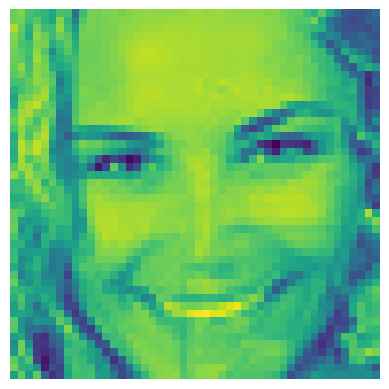

happy


In [29]:
import matplotlib.pyplot as plt

img = Image.open('/kaggle/input/fer2013/test/happy/PrivateTest_10077120.jpg')

# Display using matplotlib
plt.imshow(img)
plt.axis('off') 
plt.show()

# Predict emotion
print(predict_emotion(model, '/kaggle/input/fer2013/test/happy/PrivateTest_10077120.jpg')[0])